<a href="https://colab.research.google.com/github/MokkeMeguru/glow-realnvp-tutorial/blob/master/examples/jupyter_notebooks/Glow_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

##### Original code
https://github.com/MokkeMeguru/glow-realnvp-tutorial/

If you have any Problem, please let me(@MokkeMeguru) it.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Bijector: Glow x MNIST

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/glow_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/glow_mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example we show how to build a Glow using TFP's "Bijector."

# Glow

Difference from RealNVP 

- Invertible 1x1 convolution
- Actnorm

## Invertible 1x1 convolution

RealNVP uses Permutation by the channel dimention for Affine Coupling Layer. (Intuitively、we want to replace $x_a$ and $x_b$, I think...)

In Glow, the Permutaion is changed to the Invertible 1x1 convolution he proposed. It's a learnable layer (bijector).

formula

1. forward function
2. reverse function
3. log determinant

## Actnorm
Instead of Batch Normalization

Week points of Batch Normalization
1. IF batch size is small, it may decrease performance. (In flow base model, Batch size is often too small since this model needs large memory...)


Behavior of Actnorm
1. normalize by **channel-wise** , using the **first batch**
2. initialize weights by the normalize parameter. (bias and scale)
3. learn these weights since next batch.

# Problem Setting
Multivariate normal distribution $\leftrightarrow$ MNIST dataset

# Use Tensorflow
## Implementation Plan
0. Preprocess
1. Create Dataset
2. Build Multi-Scale Model
    1. Invertible 1x1 convolution Bijector
    2. Actnorm Bijector
    3. Multi-Scale Model
4. Build Model
    1. TransformDistribution
    2. Loss, Optimizar
    3. Training
    4. Inference

## Preprocess

In [0]:
!pip install tensorflow-gpu==2.1.0rc0 tensorflow_probability==0.8.0 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.1.0-rc0
tensorflow-probability:  0.8.0


## Create Dataset
ref. [realnvp's tutorial](./RealNVP_mnist_en.ipynb)

### Create Target Distibution ($z$)
In this part, use Multivariate normal distribution

In [0]:
# Tensorflow's distribution
z = tf.random.normal([2, 2, 256])
print('Tensorflow             : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))
# Tensorflow Probability's distribution
target_dist = tfd.Normal(loc=0., scale=1.)
z = target_dist.sample([2, 2, 256])
print('Tensorflow Probability : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))

Tensorflow             : shape: (2, 2, 256) mean: -0.006551 sd: 1.040703
Tensorflow Probability : shape: (2, 2, 256) mean: 0.060990 sd: 1.012849


### Create Original Distribution (MNIST)

In [0]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

print('train_dataset: {} images'.format(len(train_x)))
print('test_dataset : {} images'.format(len(test_x)))

train_dataset: 60000 images
test_dataset : 10000 images


In [0]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64


@tf.function
def _parse_function(img, label):
    feature = {}
    img = tf.pad(img, paddings=[[2, 2], [2, 2]], mode="CONSTANT")
    img = tf.expand_dims(img, axis=-1)
    img = tf.reshape(img, [32, 32, 1])
    img = tf.cast(img, dtype=tf.float32)
    img = (img / (255.0 / 2)) - 1
    feature["img"] = img
    feature["label"] = label
    return feature


train_dataset_raw = tf.data.Dataset.from_tensor_slices((train_x, train_y)).map(
    _parse_function
)
test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_x, test_y)).map(
    _parse_function
)

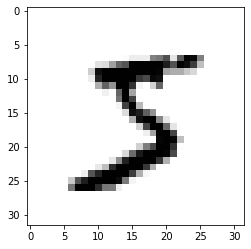

In [0]:
for image_features in train_dataset_raw.take(1):
    plt.imshow(tf.squeeze(image_features['img'], axis=-1), cmap='gray_r')

## Build Multi-Scale Model

### Invertive 1x1 convolution Bijector
ref. 
- Tensorflow Probability's implementation tensorflow_probability/bijector/MatvecLU 
- the issue https://github.com/tensorflow/probability/issues/545 

In [0]:
def trainable_lu_factorization(event_size,
                               batch_shape=(),
                               seed=None,
                               dtype=tf.float32,
                               name=None):
    with tf.name_scope('trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(event_size,
                                          dtype=tf.int32,
                                          name='event_size')
        batch_shape = tf.convert_to_tensor(batch_shape,
                                           dtype=event_size.dtype,
                                           name='batch_shape')
        random_matrix = tf.Variable(tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed,
        ),
                                    name='conv1x1_weights')

        def lu_p(m):
            return tf.linalg.lu(tf.linalg.qr(m).q)

        # lower_upper = tfp.util.DeferredTensor(lambda m: lu_p(m)[0],
        #                                       random_matrix)
        # permutation = tfp.util.DeferredTensor(lambda m: lu_p(m)[1],
        #                                       random_matrix,
        #                                       # trainable=False,
        #                                       dtype=tf.int32,
        #                                       shape=random_matrix.shape[:-1])
        lower_upper = tf.Variable(lu_p(random_matrix)[0], name='lower_upper')
        # ref https://github.com/tensorflow/probability/issues/545
        permutation = tf.Variable(lu_p(random_matrix)[1], trainable=False, name='permutation')
        return lower_upper, permutation


def build_model(channels=3):
    # conv1x1 setup
    t_lower_upper, t_permutation = trainable_lu_factorization(channels)
    conv1x1 = tfb.MatvecLU(t_lower_upper, t_permutation, name='MatvecLU')
    print('conv1x1 variable\n', conv1x1.variables)
    inv_conv1x1 = tfb.Invert(conv1x1)

    # forward setup
    fwd = tfp.layers.DistributionLambda(
        lambda x: conv1x1(tfd.Deterministic(x)))
    fwd.vars = conv1x1.trainable_variables

    # inverse setup
    inv = tfp.layers.DistributionLambda(
        lambda x: inv_conv1x1(tfd.Deterministic(x)))
    inv.vars = inv_conv1x1.trainable_variables
    
    x: tf.Tensor = tf.keras.Input(shape=[28, 28, channels])
    fwd_x: tfp.distributions.TransformedDistribution = fwd(x)
    rev_fwd_x: tfp.distributions.TransformedDistribution = inv(fwd_x)
    example_model = tf.keras.Model(inputs=x, outputs=rev_fwd_x, name='conv1x1')
    return example_model


def test_conv1x1():
    example_model = build_model()
    example_model.trainable = True
    example_model.summary()

    real_x = tf.random.uniform(shape=[2, 28, 28, 3], dtype=tf.float32)
    if example_model.weights == []:
        print('No Trainable Variable exists')
    else:
        print('Some Trainable Variables exist')

    with tf.GradientTape() as tape:
        tape.watch(real_x)
        out_x = example_model(real_x)
        out_x = out_x
        loss = out_x - real_x
    print(tf.math.reduce_sum(real_x - out_x))
    # => nealy 0
    # ex. tf.Tensor(1.3522818e-05, shape=(), dtype=float32)

    try:
        print(tape.gradient(loss, real_x).shape)
    except Exception as e:
        print('Cannot Calculate Gradient')
        print(e)
        
test_conv1x1()

conv1x1 variable
 (<tf.Variable 'trainable_lu_factorization/lower_upper:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.8432872 ,  0.5080173 ,  0.17545667],
       [ 0.6176807 , -1.0058267 , -0.6081466 ],
       [ 0.15708762,  0.5892123 ,  1.1789662 ]], dtype=float32)>, <tf.Variable 'trainable_lu_factorization/permutation:0' shape=(3,) dtype=int32, numpy=array([0, 1, 2], dtype=int32)>)
Model: "conv1x1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
distribution_lambda (Distrib ((None, 28, 28, 3), (None 9         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 28, 28, 3), (None 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Some 

### Actnorm Bijector
Notice: Initialize by the **First Batch**

※ By the way, Actnorm implementation by OpenAI https://github.com/openai/glow/blob/master/tfops.py#L71-L87　is not same as their paper's formula, I think...     
Forward's formula may be $(x + b) \odot s$ ...

In [0]:
class Actnorm(tfb.Bijector):
    def __init__(self, channels:int, validate_args=False, name='actnorm', log_scale_factor=1.0):
        super(Actnorm, self).__init__(
            # this bijector affect vector-wise (channel-wise) => forward_min_event_ndims=1
            forward_min_event_ndims=1,
            validate_args=validate_args,
            name=name
        )
        self.log_scale_factor = log_scale_factor
        self.initialized = False
        self.log_scale = tf.Variable(tf.random.normal([channels]))
        self.bias = tf.Variable(tf.random.normal([channels]))
        
    def setStat(self, x):
        mean = tf.math.reduce_mean(x, axis=[0, 1, 2])
        var = tf.math.reduce_mean((x - mean) ** 2, axis=[0, 1, 2])
        stdvar = tf.math.sqrt(var) + 1e-6
        log_scale = tf.math.log(1./ stdvar / self.log_scale_factor) * self.log_scale_factor
        self.bias.assign(- mean)
        self.log_scale.assign(log_scale)

    def _forward(self, x):
        if not self.initialized:
            self.setStat(x)
            self.initialized = True
        return (x + self.bias) * tf.exp(self.log_scale)
    
    def _inverse(self, y):
        if not self.initialized:
            self.setStat(y)
            self.initialized = True
        return y * tf.exp(- self.log_scale) - self.bias
    
    def _forward_log_det_jacobian(self, x):
        return tf.reduce_sum(self.log_scale)

    def _inverse_log_det_jacobian(self, y):
        return - tf.reduce_sum(self.log_scale)
    
def test_actnorm():
    actnorm = Actnorm(4)
    x = tf.random.normal([100, 16, 16, 4]) + 100
    y = actnorm.forward(x)
    z = actnorm.inverse(y)
    print('input: x', tf.reduce_mean(x, axis=[0, 1, 2]).numpy())
    print('output: y', tf.reduce_mean(y, axis=[0, 1, 2]).numpy())
    print('inverse: z', tf.reduce_mean(z, axis=[0, 1, 2]).numpy())
    print('log_det_jacobian: ', actnorm.forward_log_det_jacobian(y, event_ndims=3).numpy())

test_actnorm()

input: x [100.00512   99.998825  99.99571   99.99652 ]
output: y [-7.5314938e-06  5.6929143e-06 -7.4279310e-06  4.2149422e-06]
inverse: z [100.00512   99.998825  99.99571   99.99652 ]
log_det_jacobian:  0.6981194


### Multi-Scale Model
Implement blueprint    
![](https://github.com/MokkeMeguru/glow-realnvp-tutorial/blob/master/examples/img/multi-scale-arch.png?raw=1)

#### Some Utility Class (see. RealNVP_mnist.py)
ref. https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/models/

In [0]:
from tensorflow.keras.layers import Layer, Conv2D

# ref RealNVP_mnist.ipynb
class NN(Layer):
    def __init__(self,
                 input_shape,
                 n_hidden=[512, 512],
                 kernel_size=[[3, 3], [1, 1]],
                 strides=[[1, 1], [1, 1]],
                 activation="relu",
                 name=None):
        if name:
            super(NN, self).__init__(name=name)
        else:
            super(NN, self).__init__()
        layer_list = []
        for i, (hidden, kernel,
                stride) in enumerate(zip(n_hidden, kernel_size, strides)):
            layer_list.append(
                Conv2D(
                    hidden,
                    kernel_size=kernel,
                    strides=stride,
                    activation=activation,
                    padding='SAME',
                    name="dense_{}_1".format(i),
                ))
        self.layer_list = layer_list
        self.log_s_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            activation="tanh",
            name="log_s",
        )
        self.t_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            name="t",
        )

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

class RealNVP(tfb.Bijector):
    def __init__(
            self,
            input_shape,
            forward_min_event_ndims=3,
            validate_args: bool = False,
            name="real_nvp",
            n_hidden=[512, 512],
            **kargs,
    ):
        super(RealNVP, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=forward_min_event_ndims,
            name=name,
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(
            input_shape[-1] // 2,
            n_hidden=n_hidden,
        )
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name=self.name + "/nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return tf.reduce_sum(log_s)
    
class Blockwise3D(tfb.Bijector):
    def __init__(self,
                 bijectors: list,
                 block_sizes: list = None,
                 validate_args=False,
                 name=None):
        if not name:
            name = "blockwise3D_of_" + "_and_".join(
                [b.name for b in bijectors])
            name = name.replace("/", "")
        super(Blockwise3D, self).__init__(
            forward_min_event_ndims=3,
            validate_args=validate_args,
            name=name,
        )
        self._bijectors = bijectors
        self._block_sizes = block_sizes

    @property
    def bijectors(self):
        return self._bijectors

    @property
    def block_sizes(self):
        return self._block_sizes

    def _forward(self, x):
        split_x = (tf.split(x, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       x, self.block_sizes, axis=-1))
        split_y = [b.forward(x_) for b, x_ in zip(self.bijectors, split_x)]
        y = tf.concat(split_y, axis=-1)
        return y

    def _inverse(self, y):
        split_y = (tf.split(y, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       y, self.block_sizes, axis=-1))
        split_x = [b.inverse(y_) for b, y_ in zip(self.bijectors, split_y)]
        x = tf.concat(split_x, axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        split_x = (tf.split(x, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       x, self.block_sizes, axis=-1))
        fldjs = [
            b.forward_log_det_jacobian(x_, event_ndims=3)
            for b, x_ in zip(self.bijectors, split_x)
        ]
        return sum(fldjs)

    def _inverse_log_det_jacobian(self, y):
        split_y = (tf.split(y, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       y, self.block_sizes, axis=-1))
        ildjs = [
            b.inverse_log_det_jacobian(y_, event_ndims=3)
            for b, y_ in zip(self.bijectors, split_y)
        ]
        return sum(ildjs)
    
class Squeeze3D(tfb.Bijector):
    def __init__(
            self,
            factor=2,
            forward_min_event_ndims=0,
            inverse_min_event_ndims=0,
            validate_args=False,
            name="Squeeze",
    ):
        self._factor = factor
        super(Squeeze3D,
              self).__init__(forward_min_event_ndims=forward_min_event_ndims,
                             inverse_min_event_ndims=inverse_min_event_ndims,
                             name=name,
                             is_constant_jacobian=True)

    @property
    def factor(self):
        return self._factor

    def _forward(self, x):
        (H, W, C) = x.shape[1:]
        batch_size = tf.shape(x)[0:1]
        tmp_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, self.factor, W // self.factor, self.factor,
                 C),
            ],
            axis=0,
        )
        output_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, W // self.factor, C * self.factor**2)
            ],
            axis=0,
        )
        y = tf.reshape(x, tmp_shape)
        y = tf.transpose(y, [0, 1, 3, 5, 2, 4])
        y = tf.reshape(y, output_shape)
        return y

    def _inverse(self, y):
        (H, W, C) = y.shape[1:]
        batch_size = tf.shape(y)[0:1]
        tmp_shape = tf.concat([
            batch_size, (H, W, C // self.factor**2, self.factor, self.factor)
        ],
                              axis=0)
        output_shape = tf.concat([
            batch_size, (H * self.factor, W * self.factor, C // self.factor**2)
        ],
                                 axis=0)
        x = tf.reshape(y, tmp_shape)
        x = tf.transpose(x, [0, 1, 4, 2, 5, 3])
        x = tf.reshape(x, output_shape)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)

In [0]:
def gen_flowSteps(
    # for realnvp
    input_shape: list,
    n_hidden: list = [128, 128],
    # for flowStep
    k=4,
    forward_min_event_ndims: int = 3,
    validate_args: bool = False,
    name: str = "flow_step",
):
    flow_step_list = []
    for i in range(k):
        t_lower_upper, t_permutation = trainable_lu_factorization(input_shape[-1])
        flow_step_list.append(Actnorm(input_shape[-1]))
        flow_step_list.append(
            tfb.MatvecLU(
                t_lower_upper, t_permutation, name="{}_{}/matveclu".format(name, i)
            )
        ),
        flow_step_list.append(
            RealNVP(
                input_shape=input_shape,
                n_hidden=n_hidden,
                validate_args=validate_args,
                name="{}_{}/realnvp".format(name, i),
            )
        )

    flowSteps = tfb.Chain(
        list(reversed(flow_step_list)), validate_args=validate_args, name=name
    )
    return flowSteps


def test_gen_flowSteps():
    flowSteps = gen_flowSteps(
        k=2, input_shape=[16, 16, 4], forward_min_event_ndims=0, name="flowstep_0"
    )
    x = tf.keras.Input([16, 16, 4])
    y = flowSteps(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([6, 16, 16, 4])
    y = flowSteps.forward(x)
    z = flowSteps.inverse(y)
    return tf.reduce_sum(z - x)


test_gen_flowSteps()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [0]:
def gen_flow(input_shape, level=3, flow_step_args: dict = None):
    def _gen_input_shapes(input_shape, level):
        input_shape = input_shape
        input_shapes = []
        for i in range(level):
            input_shape = [
                input_shape[0] // 2,
                input_shape[1] // 2,
                input_shape[2] * 2,
            ]
            input_shapes.append(input_shape)
        return input_shapes

    input_shape[-1] = input_shape[-1] * 2
    input_shapes = _gen_input_shapes(input_shape, level)

    def _add_flow(_input_shapes, flow_step_args):
        flow_lists = []
        flow_lists.append(
            Squeeze3D(name="Squeeze_{}".format(level - len(_input_shapes)))
        )
        flowSteps = gen_flowSteps(
           k=2,
           input_shape=_input_shapes[0],
           name="Flowsteps_{}".format(level - len(_input_shapes)),
        )
        flow_lists.append(flowSteps)
        if len(_input_shapes) != 1:
            flow_lists.append(
                Blockwise3D(
                    [
                        tfb.Identity(),
                        tfb.Chain(
                            list(reversed(_add_flow(_input_shapes[1:], flow_step_args)))
                        ),
                    ],
                    name="Blockwise3D_{}".format(level - len(_input_shapes)),
                )
            )
        flow_lists.append(
            tfb.Invert(
                Squeeze3D(name="Unsqueeze_{}".format(level - len(_input_shapes)))
            )
        )
        return flow_lists

    return tfb.Chain(list(reversed(_add_flow(input_shapes, level))))


def test_gen_flow():
    flow = gen_flow([32, 32, 1])
    print(len(flow.trainable_variables))
    x = tf.keras.Input([32, 32, 1])
    y = flow.forward(x)
    # tf.keras.Model(x, y).summary()
    tf.keras.utils.plot_model(
        tf.keras.Model(x, y), show_shapes=True, to_file="realnvp.png"
    )
    x = tf.random.normal([3, 32, 32, 1])
    y = flow.forward(x)
    z = flow.inverse(y) 
    return tf.reduce_sum(z - x)

test_gen_flow()

66


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## Build Model

### TransformDistribution

In [0]:
flow_bijector = gen_flow([32, 32, 1], level=3)
print(len(flow_bijector.trainable_variables))
flow = tfd.TransformedDistribution(
    event_shape =[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=flow_bijector
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

66
trainable_variables:  66


### Loss, Optimizer

In [0]:
# !rm -r checkpoints

In [0]:
@tf.function
def loss():
    return - tf.reduce_mean(flow.log_prob(targets['img'])) / (np.log(2.) * 32 * 32 * 1)


optimizer = tf.optimizers.Adam(learning_rate=1e-5) 
# log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [0]:
BATCH_SIZE=120
train_dataset = train_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
for target in train_dataset.take(1):
    targets = target
print(targets['img'].shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, flow.trainable_variables)
print(log_prob_loss)

(120, 32, 32, 1)
tf.Tensor(898662300.0, shape=(), dtype=float32)


### Training

In [0]:
n_epochs = 120
from tqdm import tqdm
flag = False
for epoch in range(n_epochs):
    if flag:
        print('raise NaN')
        break
    for targets in tqdm(train_dataset):
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        if tf.math.is_nan(log_prob_loss):
            flag=True
            break
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 1000, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
        if tf.equal(optimizer.iterations % 100, 0):
            # with log.as_default():
            #     tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
            #     avg_loss.reset_states()
            avg_loss.reset_states()

500it [00:40, 12.50it/s]
500it [00:40, 13.35it/s]
1it [00:00,  6.68it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss 92662.679688


500it [00:39, 12.56it/s]
500it [00:40, 12.44it/s]
1it [00:00,  7.87it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2000> Loss 7071.515625


500it [00:40, 12.36it/s]
500it [00:40, 12.34it/s]
1it [00:00,  7.61it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=3000> Loss 2061.264404


500it [00:40, 12.23it/s]
500it [00:40, 12.45it/s]
1it [00:00,  7.56it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=4000> Loss 973.552979


500it [00:40, 12.46it/s]
500it [00:40, 12.37it/s]
1it [00:00,  7.48it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=5000> Loss 564.965332


500it [00:40, 12.40it/s]
500it [00:40, 12.39it/s]
1it [00:00,  7.55it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=6000> Loss 375.461456


500it [00:40, 12.41it/s]
500it [00:40, 12.38it/s]
1it [00:00,  7.25it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=7000> Loss 274.638672


500it [00:40, 12.20it/s]
500it [00:40, 12.31it/s]
1it [00:00,  7.31it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=8000> Loss 215.854965


500it [00:40, 12.35it/s]
500it [00:40, 12.40it/s]
1it [00:00,  7.70it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=9000> Loss 186.470901


500it [00:40, 12.44it/s]
500it [00:40, 12.39it/s]
1it [00:00,  7.62it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=10000> Loss 158.986191


500it [00:41, 12.19it/s]
500it [00:41, 12.05it/s]
1it [00:00,  6.11it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=11000> Loss 105.353790


500it [00:41, 12.07it/s]
500it [00:41, 12.06it/s]
1it [00:00,  7.18it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=12000> Loss 50.882988


500it [00:40, 12.20it/s]
500it [00:41, 11.96it/s]
1it [00:00,  7.77it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=13000> Loss 25.865776


500it [00:41, 12.16it/s]
500it [00:40, 12.21it/s]
1it [00:00,  7.60it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=14000> Loss 2.423230


500it [00:41, 12.16it/s]
500it [00:41, 11.91it/s]
1it [00:00,  6.70it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=15000> Loss -23.790869


500it [00:41, 12.00it/s]
500it [00:41, 12.03it/s]
1it [00:00,  6.59it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=16000> Loss -51.666309


500it [00:41, 12.09it/s]
500it [00:41, 12.17it/s]
1it [00:00,  6.99it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=17000> Loss -83.094589


500it [00:42, 11.84it/s]
500it [00:41, 12.14it/s]
1it [00:00,  6.87it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=18000> Loss -107.500755


500it [00:41, 12.00it/s]
500it [00:42, 11.82it/s]
1it [00:00,  7.11it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=19000> Loss -129.508560


500it [00:40, 12.20it/s]
500it [00:41, 13.00it/s]
1it [00:00,  7.34it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=20000> Loss -148.671402


500it [00:40, 12.25it/s]
500it [00:40, 12.28it/s]
1it [00:00,  7.23it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=21000> Loss -162.397186


500it [00:40, 12.22it/s]
500it [00:40, 12.33it/s]
1it [00:00,  7.26it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=22000> Loss -172.440140


500it [00:44, 12.31it/s]
500it [00:41, 12.06it/s]
1it [00:00,  7.48it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=23000> Loss -214.407166


500it [00:41, 12.62it/s]
500it [00:41, 12.08it/s]
1it [00:00,  7.87it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=24000> Loss -246.476334


500it [00:41, 12.09it/s]
500it [00:41, 12.08it/s]
1it [00:00,  6.95it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=25000> Loss -257.512848


500it [00:41, 12.09it/s]
500it [00:41, 12.04it/s]
1it [00:00,  7.43it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=26000> Loss -263.458801


500it [00:41, 12.08it/s]
500it [00:40, 12.24it/s]
1it [00:00,  6.78it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=27000> Loss -267.299988


500it [00:41, 11.97it/s]
500it [00:41, 12.11it/s]
1it [00:00,  6.98it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=28000> Loss -270.574402


500it [00:41, 12.12it/s]
500it [00:41, 12.09it/s]
1it [00:00,  6.80it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=29000> Loss -272.203949


500it [00:41, 11.97it/s]
500it [00:41, 12.06it/s]
1it [00:00,  6.53it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=30000> Loss -273.450470


500it [00:41, 12.12it/s]
500it [00:41, 12.17it/s]
1it [00:00,  7.47it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=31000> Loss -274.862793


500it [00:41, 13.01it/s]
500it [00:40, 12.20it/s]
1it [00:00,  7.07it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=32000> Loss -276.437683


500it [00:41, 12.14it/s]
500it [00:40, 12.24it/s]
1it [00:00,  6.65it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=33000> Loss -278.137329


500it [00:41, 12.52it/s]
500it [00:40, 12.25it/s]
1it [00:00,  6.72it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=34000> Loss -280.028717


500it [00:41, 12.15it/s]
500it [00:40, 12.29it/s]
1it [00:00,  7.23it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=35000> Loss -282.131836


500it [00:40, 12.21it/s]
500it [00:40, 12.23it/s]
1it [00:00,  7.35it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=36000> Loss -277.561768


500it [00:40, 12.20it/s]
500it [00:41, 12.17it/s]
1it [00:00,  7.09it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=37000> Loss -282.231750


500it [00:41, 12.16it/s]
500it [00:40, 12.28it/s]
1it [00:00,  7.53it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=38000> Loss -282.974884


500it [00:40, 12.46it/s]
500it [00:40, 12.36it/s]
1it [00:00,  7.23it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=39000> Loss -282.838409


500it [00:40, 12.23it/s]
500it [00:40, 12.28it/s]
1it [00:00,  6.94it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=40000> Loss -282.697449


500it [00:40, 12.26it/s]
500it [00:41, 12.31it/s]
1it [00:00,  7.06it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=41000> Loss -282.894897


500it [00:40, 13.15it/s]
500it [00:40, 12.29it/s]
1it [00:00,  6.98it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=42000> Loss -283.240906


500it [00:40, 12.25it/s]
500it [00:40, 12.34it/s]
1it [00:00,  7.30it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=43000> Loss -283.657440


500it [00:40, 12.27it/s]
500it [00:40, 12.29it/s]
1it [00:00,  6.93it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=44000> Loss -284.122223


500it [00:40, 13.18it/s]
500it [00:41, 12.17it/s]
1it [00:00,  7.21it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=45000> Loss -284.675812


500it [00:40, 12.20it/s]
500it [00:40, 12.23it/s]
1it [00:00,  6.83it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=46000> Loss -285.305695


500it [00:40, 12.27it/s]
500it [00:40, 12.23it/s]
1it [00:00,  7.52it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=47000> Loss -286.019562


500it [00:40, 12.26it/s]
500it [00:40, 12.29it/s]
1it [00:00,  6.72it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=48000> Loss -286.851929


500it [00:40, 12.23it/s]
500it [00:41, 12.11it/s]
1it [00:00,  7.65it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=49000> Loss -287.786560


500it [00:40, 12.31it/s]
500it [00:40, 12.22it/s]
1it [00:00,  7.47it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=50000> Loss -288.878174


500it [00:40, 12.25it/s]
500it [00:40, 12.26it/s]
1it [00:00,  6.64it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=51000> Loss -289.765808


500it [00:41, 12.18it/s]
500it [00:41, 12.11it/s]
1it [00:00,  7.52it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=52000> Loss -290.141724


500it [00:41, 11.98it/s]
500it [00:40, 12.20it/s]
1it [00:00,  7.65it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=53000> Loss -290.499084


500it [00:41, 12.15it/s]
500it [00:42, 11.71it/s]
1it [00:00,  6.91it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=54000> Loss -290.905457


500it [00:41, 12.14it/s]
500it [00:41, 12.12it/s]
1it [00:00,  7.15it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=55000> Loss -291.377167


500it [00:41, 12.73it/s]
500it [00:41, 12.05it/s]
1it [00:00,  6.22it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=56000> Loss -291.931152


500it [00:41, 12.04it/s]
500it [00:41, 12.03it/s]
1it [00:00,  7.19it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=57000> Loss -292.566803


500it [00:40, 12.25it/s]
500it [00:41, 12.11it/s]
1it [00:00,  6.97it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=58000> Loss -293.278809


500it [00:40, 12.22it/s]
500it [00:41, 12.18it/s]
1it [00:00,  7.24it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=59000> Loss -294.093201


500it [00:40, 12.95it/s]
500it [00:41, 12.10it/s]

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=60000> Loss -212.380447


### Inference

In [0]:
test_dataset = test_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

log probability:  -1.3534642
inv mean:  -0.4333917  std:  0.8253626
re:trg mean:  -0.8132636  std:  0.5319577


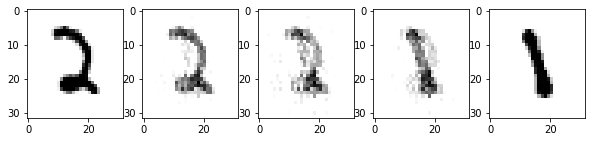

In [0]:
fig = plt.figure(figsize=(10, 2))
for targets in test_dataset.take(1):
    trg = targets["img"]
    inv = flow.bijector.forward(trg)
    re_trg = flow.bijector.inverse(inv)

print('log probability: ', (tf.reduce_mean(flow.log_prob(inv)) / (np.log(2.) * 32 * 32 * 1)).numpy())
print("inv mean: ", tf.reduce_mean(inv).numpy(), " std: ", tf.math.reduce_std(inv).numpy())
print("re:trg mean: ", tf.reduce_mean(re_trg).numpy(), " std: ", tf.math.reduce_std(re_trg).numpy())

def  interporate(a, b, percent):
  re_inv = np.array([(percent * a +  (1 - percent) * b)])
  re_re_inv = flow.bijector.inverse(re_inv)
  return tf.nn.relu6(re_re_inv - tf.reduce_mean(re_re_inv))
# re_inv = np.array([(inv[0] + inv[1]) / 2.0])
# print(re_inv.shape)
#print(tf.reduce_mean(re_inv))
# re_re_trg = flow.bijector.inverse(re_inv)


ax = fig.add_subplot(1, 5, 1)
ax.imshow(tf.squeeze(re_trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 2)
ax.imshow(tf.squeeze(interporate(inv[0], inv[1], 0.75)[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 3)
ax.imshow(tf.squeeze(interporate(inv[0], inv[1], 0.5)[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 4)
ax.imshow(tf.squeeze(interporate(inv[0], inv[1], 0.25)[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 5)
ax.imshow(tf.squeeze(re_trg[1], axis=-1), aspect="auto", cmap="gray_r")

# ax = fig.add_subplot(2, 3, 3)
# ax.imshow(tf.squeeze(re_inv[0], axis=-1), aspect="auto", cmap="gray_r")

# ax = fig.add_subplot(2, 3, 6)
#ax.imshow(tf.squeeze(tf.nn.relu6(re_re_trg[0] - tf.reduce_mean(re_re_trg)), axis=-1), aspect="auto", cmap="gray_r")